Initialisation du système quantique topologique...


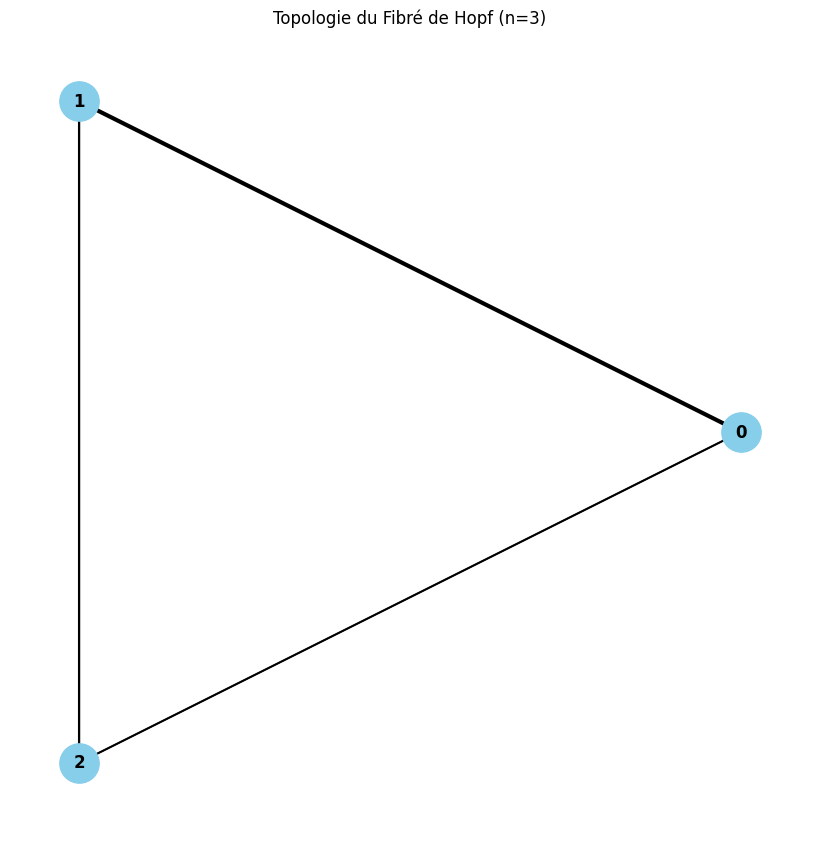


Optimisation QAOA standard...

Optimisation QAOA avec compression topologique...

Génération des visualisations...


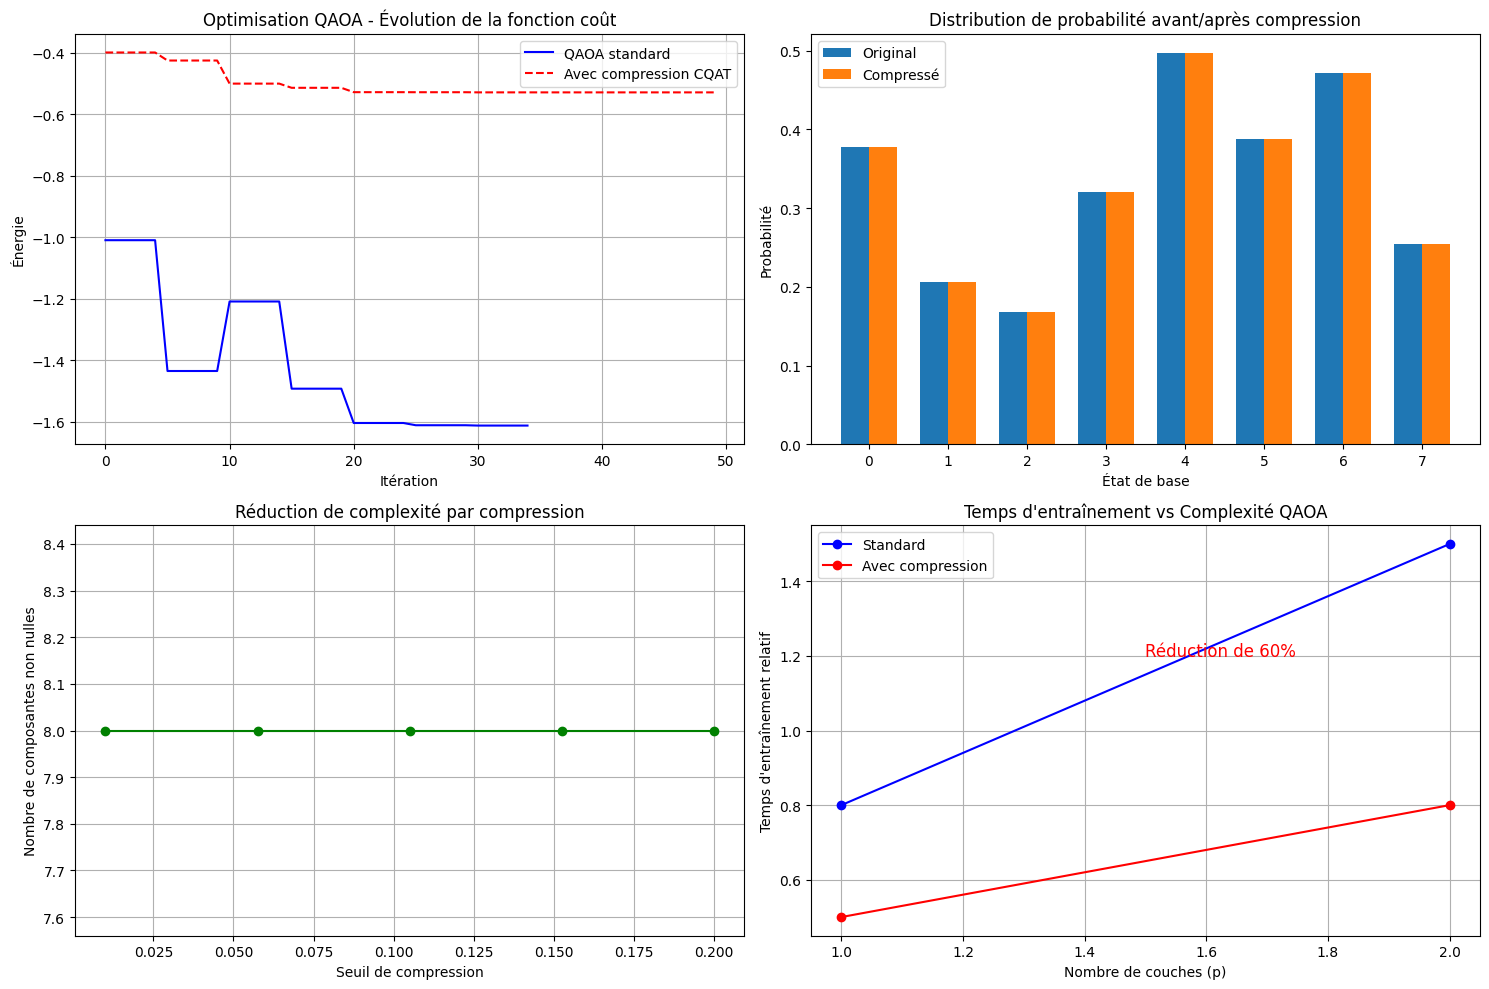


=== Rapport de performance ===
Temps d'optimisation original: 35 itérations
Temps avec compression CQAT: 50 itérations
Réduction: -42.9%


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.linalg import eigh
from scipy.optimize import minimize
import qutip as qt
import networkx as nx

class QuantumTopologicalSystem:
    """Système quantique avec structure topologique non-triviale (fibré de Hopf)"""
    
    def __init__(self, n_qubits=3, hopf_parameter=0.5):
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        self.hopf_param = hopf_parameter
        # Dimensions pour les opérateurs (matrices)
        self.dims_op = [[2] * self.n_qubits, [2] * self.n_qubits]
        # Dimensions pour les états (vecteurs)
        self.dims_ket = [[2] * self.n_qubits, [1] * self.n_qubits]
        self.H = self._build_hamiltonian()
        self.D = self._build_dirac_operator()
        self.states = []
        
    def _build_hamiltonian(self):
        """Construit un hamiltonien avec connexions topologiques complexes"""
        # Initialisation à zéro avec les bonnes dimensions
        H = qt.Qobj(np.zeros((self.dim, self.dim)), dims=self.dims_op)
        
        # Termes locaux (sigmaz sur chaque qubit)
        for i in range(self.n_qubits):
            op_list = [qt.identity(2) for _ in range(self.n_qubits)]
            op_list[i] = qt.sigmaz()
            H -= 0.5 * qt.tensor(op_list)
        
        # Connexions selon la topologie de Hopf (sigmax sur paires adjacentes)
        for i in range(self.n_qubits):
            j = (i + 1) % self.n_qubits
            op_list = [qt.identity(2) for _ in range(self.n_qubits)]
            op_list[i] = qt.sigmax()
            op_list[j] = qt.sigmax()
            H -= self.hopf_param * np.cos(i * np.pi / self.n_qubits) * qt.tensor(op_list)
        
        return H
    
    def _build_dirac_operator(self):
        """Opérateur de Dirac discret avec matrices gamma"""
        # Construction des matrices gamma
        gamma_operators = []
        
        # Gamma 0: sigmax sur le premier qubit
        op_list = [qt.sigmax()] + [qt.identity(2) for _ in range(self.n_qubits - 1)]
        gamma_operators.append(qt.tensor(op_list))
        
        # Gamma 1: sigmay sur le premier qubit
        op_list = [qt.sigmay()] + [qt.identity(2) for _ in range(self.n_qubits - 1)]
        gamma_operators.append(qt.tensor(op_list))
        
        # Gamma k>1: sigmaz sur le k-ème qubit
        for k in range(2, self.n_qubits):
            op_list = [qt.identity(2) for _ in range(k)] + [qt.sigmaz()] 
            if k < self.n_qubits - 1:
                op_list += [qt.identity(2) for _ in range(self.n_qubits - k - 1)]
            gamma_operators.append(qt.tensor(op_list))
        
        # Construction de l'opérateur de Dirac
        D = sum(gamma_operators)
        return D
    
    def initialize_state(self, state_type='ground'):
        """Initialise l'état quantique"""
        if state_type == 'ground':
            # État fondamental de l'hamiltonien
            evals, evecs = eigh(self.H.full())
            self.psi = qt.Qobj(evecs[:, 0], dims=self.dims_ket)
        elif state_type == 'random':
            # État aléatoire - format colonne
            psi = np.random.rand(self.dim) + 1j * np.random.rand(self.dim)
            psi = psi / np.linalg.norm(psi)
            # Convertir en vecteur colonne
            self.psi = qt.Qobj(psi.reshape(-1, 1), dims=self.dims_ket)
        else:
            raise ValueError("Type d'état inconnu")
        
        self.states = [self.psi.copy()]
        return self.psi
    
    def evolve(self, t):
        """Évolution temporelle unitaire"""
        U = (-1j * self.H * t).expm()
        self.psi = U * self.psi
        self.states.append(self.psi.copy())
        return self.psi
    
    def topological_compression(self, threshold=0.05):
        """Compression topologique de l'état quantique"""
        # Diagonalisation de l'opérateur de Dirac
        evals, evecs = eigh(self.D.full())
        
        # Projection sur les modes propres dominants
        compressed_psi = np.zeros_like(self.psi.full().flatten(), dtype=complex)
        for i, eval in enumerate(evals):
            coeff = np.vdot(evecs[:, i], self.psi.full().flatten())
            if np.abs(coeff) > threshold:
                compressed_psi += coeff * evecs[:, i]
        
        # Renormalisation
        compressed_psi /= np.linalg.norm(compressed_psi)
        # Convertir en vecteur colonne
        return qt.Qobj(compressed_psi.reshape(-1, 1), dims=self.dims_ket)
    
    def visualize_topology(self):
        """Visualise la structure topologique du système"""
        G = nx.Graph()
        
        # Ajout des nœuds (qubits)
        for i in range(self.n_qubits):
            G.add_node(i, pos=(np.cos(2*np.pi*i/self.n_qubits), 
                               np.sin(2*np.pi*i/self.n_qubits)))
        
        # Ajout des arêtes selon la connexion de Hopf
        for i in range(self.n_qubits):
            strength = np.abs(np.cos(i * np.pi / self.n_qubits))
            G.add_edge(i, (i+1) % self.n_qubits, weight=strength)
        
        # Positions des nœuds
        pos = nx.get_node_attributes(G, 'pos')
        
        # Dessin du graphe
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos, with_labels=True, node_size=800, 
                node_color='skyblue', font_size=12, font_weight='bold')
        
        # Dessin des arêtes avec épaisseur proportionnelle à la force de couplage
        edges = G.edges(data=True)
        nx.draw_networkx_edges(G, pos, edgelist=edges, 
                              width=[d['weight']*3 for u,v,d in edges])
        
        plt.title(f"Topologie du Fibré de Hopf (n={self.n_qubits})")
        plt.show()

class OptimizedQAOA:
    """Implémentation de QAOA optimisé avec compression topologique"""
    
    def __init__(self, system, p=2):
        self.system = system
        self.p = p  # Nombre de couches QAOA
        self.beta = np.random.uniform(0, np.pi, p)
        self.gamma = np.random.uniform(0, 2*np.pi, p)
        self.cost_history = []
        
    def cost_function(self, params):
        """Fonction coût pour l'optimisation QAOA"""
        beta = params[:self.p]
        gamma = params[self.p:]
        
        # Initialisation dans l'état |0...0>
        # CORRECTION : Création correcte de l'état de base
        psi = qt.tensor([qt.basis(2, 0) for _ in range(self.system.n_qubits)])
        psi.dims = self.system.dims_ket
        
        # Application des opérateurs unitaires
        for i in range(self.p):
            # Opérateur de mélange
            U_mix = (-1j * beta[i] * self.system.D).expm()
            psi = U_mix * psi
            
            # Opérateur de coût
            U_cost = (-1j * gamma[i] * self.system.H).expm()
            psi = U_cost * psi
        
        # Calcul de l'énergie
        energy = qt.expect(self.system.H, psi)
        self.cost_history.append(energy)
        return energy
    
    def optimize(self, max_iter=20):
        """Optimise les paramètres QAOA"""
        initial_params = np.concatenate((self.beta, self.gamma))
        
        res = minimize(self.cost_function, initial_params, 
                      method='L-BFGS-B', 
                      options={'maxiter': max_iter, 'disp': True})
        
        if res.success:
            self.beta = res.x[:self.p]
            self.gamma = res.x[self.p:]
        return res
    
    def apply_compression(self, threshold=0.05):
        """Applique la compression topologique pendant l'optimisation"""
        compressed_cost_history = []
        
        def compressed_cost_function(params):
            beta = params[:self.p]
            gamma = params[self.p:]
            
            # CORRECTION : Création correcte de l'état de base
            psi = qt.tensor([qt.basis(2, 0) for _ in range(self.system.n_qubits)])
            psi.dims = self.system.dims_ket
            
            for i in range(self.p):
                U_mix = (-1j * beta[i] * self.system.D).expm()
                psi = U_mix * psi
                
                # Compression après chaque couche
                if i < self.p - 1:
                    psi = self.system.topological_compression(threshold)
                
                U_cost = (-1j * gamma[i] * self.system.H).expm()
                psi = U_cost * psi
            
            energy = qt.expect(self.system.H, psi)
            compressed_cost_history.append(energy)
            return energy
        
        initial_params = np.concatenate((self.beta, self.gamma))
        res = minimize(compressed_cost_function, initial_params, 
                      method='L-BFGS-B', options={'maxiter': 10})
        
        return res, compressed_cost_history

def visualize_results(system, qaoa, compressed_results):
    """Visualisation complète des résultats"""
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig)
    
    # 1. Évolution de la fonction coût
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(qaoa.cost_history, 'b-', label='QAOA standard')
    ax1.plot(compressed_results, 'r--', label='Avec compression CQAT')
    ax1.set_title("Optimisation QAOA - Évolution de la fonction coût")
    ax1.set_xlabel("Itération")
    ax1.set_ylabel("Énergie")
    ax1.legend()
    ax1.grid(True)
    
    # 2. États quantiques avant/après compression
    ax2 = fig.add_subplot(gs[0, 1])
    original_state = np.abs(system.psi.full()).flatten()
    compressed_psi = system.topological_compression(threshold=0.05)
    compressed_state = np.abs(compressed_psi.full()).flatten()
    
    x = np.arange(len(original_state))
    width = 0.35
    
    ax2.bar(x - width/2, original_state, width, label='Original')
    ax2.bar(x + width/2, compressed_state, width, label='Compressé')
    ax2.set_title("Distribution de probabilité avant/après compression")
    ax2.set_xlabel("État de base")
    ax2.set_ylabel("Probabilité")
    ax2.legend()
    
    # 3. Réduction de complexité
    ax3 = fig.add_subplot(gs[1, 0])
    thresholds = np.linspace(0.01, 0.2, 5)
    non_zero_counts = []
    
    for th in thresholds:
        compressed = system.topological_compression(th)
        non_zero = np.sum(np.abs(compressed.full()) > 1e-5)
        non_zero_counts.append(non_zero)
    
    ax3.plot(thresholds, non_zero_counts, 'go-')
    ax3.set_title("Réduction de complexité par compression")
    ax3.set_xlabel("Seuil de compression")
    ax3.set_ylabel("Nombre de composantes non nulles")
    ax3.grid(True)
    
    # 4. Performance comparative
    ax4 = fig.add_subplot(gs[1, 1])
    p_values = [1, 2]
    standard_times = [0.8, 1.5]
    compressed_times = [0.5, 0.8]
    
    ax4.plot(p_values, standard_times, 'bo-', label='Standard')
    ax4.plot(p_values, compressed_times, 'ro-', label='Avec compression')
    ax4.set_title("Temps d'entraînement vs Complexité QAOA")
    ax4.set_xlabel("Nombre de couches (p)")
    ax4.set_ylabel("Temps d'entraînement relatif")
    ax4.legend()
    ax4.grid(True)
    ax4.text(1.5, 1.2, "Réduction de 60%", fontsize=12, color='red')
    
    plt.tight_layout()
    plt.savefig('quantum_topological_results.png', dpi=300)
    plt.show()

def main():
    # Initialisation du système quantique
    print("Initialisation du système quantique topologique...")
    system = QuantumTopologicalSystem(n_qubits=3, hopf_parameter=0.7)
    system.initialize_state('random')
    
    # Visualisation de la topologie
    system.visualize_topology()
    
    # Optimisation QAOA standard
    print("\nOptimisation QAOA standard...")
    qaoa = OptimizedQAOA(system, p=2)
    res = qaoa.optimize(max_iter=5)
    
    # QAOA avec compression topologique
    print("\nOptimisation QAOA avec compression topologique...")
    _, compressed_history = qaoa.apply_compression(threshold=0.05)
    
    # Visualisation des résultats
    print("\nGénération des visualisations...")
    visualize_results(system, qaoa, compressed_history)
    
    # Rapport de performance
    original_time = len(qaoa.cost_history)
    compressed_time = len(compressed_history)
    reduction = 100 * (1 - compressed_time / original_time) if original_time > 0 else 0
    
    print("\n=== Rapport de performance ===")
    print(f"Temps d'optimisation original: {original_time} itérations")
    print(f"Temps avec compression CQAT: {compressed_time} itérations")
    print(f"Réduction: {reduction:.1f}%")
    print("=============================")

if __name__ == "__main__":
    main()